# Análisis ETL y Exploratorio de Datos de Google

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from collections import Counter
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


En el contexto de la proyección creciente de la comida y cultura argentina a nivel global, especialmente en **Florida**, este proceso ETL (Extract, Transform, Load) combinado con un Análisis Exploratorio de Datos (EDA) tiene como objetivo analizar la viabilidad de aprovechar el impulso generado por eventos recientes, como la `victoria de Argentina en el Mundial 2022` y la presencia influyente de `Lionel Messi` en el equipo `Inter de Miami` y la confirmación de la sede en Estados Unidos del próximo `mundial 2026`. Utilizando una base de datos de reseñas de diversos locales de comida en Google, se pretende evaluar la percepción de la comida argentina en Florida, identificar patrones estacionales, analizar la relación con eventos clave y determinar la demanda potencial de la cultura argentina en esta región. Estos análisis brindarán una comprensión profunda que orientará la formulación de estrategias efectivas para aprovechar las oportunidades emergentes en este contexto específico.

----

Recopilamos datos de reseñas de archivos JSON en la carpeta especificada y screamos dos columnas adicionales: `"state"` y `"year"`. La columna state almacena el nombre del estado correspondiente a los datos de reseñas y la columna year almacena el año en que se realizó la reseña. Estas columnas proporcionan información adicional que puede ser útil para el análisis posterior de los datos. Finalmente, el DataFrame resultante se guarda en formato Parquet con el nombre del estado en el archivo.

In [8]:
data = []

# sólo cambiar el nombre de la carpeta
carpeta = 'review-Florida'

# toma el nombre del estado
estado = carpeta.split('-')[1]

contador = 1

while os.path.exists(os.path.join(carpeta, f"{contador}.json")):
    file_path = os.path.join(carpeta, f"{contador}.json")
    
    with open(file_path) as json_file:
        for line in json_file:
            data.append(json.loads(line))            
    
    contador += 1

df = pd.DataFrame(data)

# agrega una columna con el estado
df['state'] = estado

# convierte a formato de fecha y hora
df['time'] = pd.to_datetime(df['time'], unit='ms')

# crea una nueva columna 'year' con el año extraído
df['year'] = df['time'].dt.year

# guarda el DF en un archivo Parquet dentro de la carpeta data
df.to_parquet(f"review-{estado}.parquet")

----

## Florida

Convertimos el archivo parquet que contiene datos de reseñas de locales a un dataframe.

In [9]:
reviews = pd.read_parquet("review-Florida.parquet")

In [10]:
reviews.head(3)

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year
0,101471856155148729010,Julie A. Gerber,2021-08-03 15:07:30.740,1,Update: Their “reply” to my review amounted to...,None,{'text': 'Thank you for the feedback. We would...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2021
1,115477234789038326051,Martin Sheffield,2020-07-18 00:13:37.005,5,He's a knowledgeable doctor but the way he run...,None,{'text': 'Thank you for reaching out. I’m forw...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2020
2,101805010244892834381,Brian Truett,2018-04-05 10:30:53.567,5,"Best doctor I've ever had, I never wait to be ...",None,None,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2018


----

A partir del archivo de base de locales, traemos la categoría para así poder trabajar solamente con los locales de las categorías en las que estamos interesados.

In [11]:
sitios = pd.read_parquet("data_filtrada.parquet")

In [12]:
sitios.head(3)

,name,address,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews,MISC,state
0,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,34.058092,-118.292130,Korean restaurant,4.4,18,{'Accessibility': ['Wheelchair accessible entr...,California
1,Vons Chicken,"Vons Chicken, 12740 La Mirada Blvd, La Mirada,...",0x80dd2b4c8555edb7:0xfc33d65c4bdbef42,33.916402,-118.010855,Restaurant,4.5,18,{'Accessibility': ['Wheelchair accessible entr...,California
2,"Sweet Rewards Gluten Free Bakery, LLC","Sweet Rewards Gluten Free Bakery, LLC, 85 NE D...",0x87ec235c54d25b31:0x3b75fb5facc602f,41.616079,-93.865487,"Bakery, Health food restaurant",4.7,21,"{'Accessibility': None, 'Activities': None, 'A...",Iowa


In [13]:
reviews = reviews.merge(sitios[['gmap_id', 'category']], on='gmap_id', how='left')

In [14]:
reviews.head(3)

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year,category
0,101471856155148729010,Julie A. Gerber,2021-08-03 15:07:30.740,1,Update: Their “reply” to my review amounted to...,None,{'text': 'Thank you for the feedback. We would...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2021,NaN
1,115477234789038326051,Martin Sheffield,2020-07-18 00:13:37.005,5,He's a knowledgeable doctor but the way he run...,None,{'text': 'Thank you for reaching out. I’m forw...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2020,NaN
2,101805010244892834381,Brian Truett,2018-04-05 10:30:53.567,5,"Best doctor I've ever had, I never wait to be ...",None,None,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2018,NaN


----

Vemos las 5 primeras filas del DataFrame para ayor comprensión de los datos.

- **user_id**: identificador único del usuario que dejó la reseña.
- **name**: nombre del usuario que dejó la reseña.
- **time**: fecha y hora en que se realizó la reseña.
- **rating**: calificación dada por el usuario.
- **text**: contenido del comentario dejado por el usuario.
- **pics**: imágenes relacionadas con la reseña.
- **resp**: respuestas del local al comentario.
- **gmap_id**: identificador de Google Maps asociado al lugar.
- **state**: estado al que pertenece el lugar.
- **year**: año en que se dejó la reseña.
- **category**: categoría a la que pertenece la reseña.

In [15]:
reviews.head()

,user_id,name,time,rating,text,pics,resp,gmap_id,state,year,category
0,101471856155148729010,Julie A. Gerber,2021-08-03 15:07:30.740,1,Update: Their “reply” to my review amounted to...,None,{'text': 'Thank you for the feedback. We would...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2021,NaN
1,115477234789038326051,Martin Sheffield,2020-07-18 00:13:37.005,5,He's a knowledgeable doctor but the way he run...,None,{'text': 'Thank you for reaching out. I’m forw...,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2020,NaN
2,101805010244892834381,Brian Truett,2018-04-05 10:30:53.567,5,"Best doctor I've ever had, I never wait to be ...",None,None,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2018,NaN
3,106344422881493743981,Tina Sun,2016-07-07 16:10:19.586,1,I was told he is a good doctor. I was trying t...,None,None,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2016,NaN
4,100875113069561776529,James Haynes,2016-12-02 12:56:55.081,5,Takes the time to actually get to know his pat...,None,None,0x8893863ea87bd5dd:0x9383ebf973e74abb,Florida,2016,NaN


----

Tamaño del DataFrame.
- Columnas: 11
- Filas: 2850000

In [16]:
reviews.shape

(2850000, 11)

----

Sólo tenemos categorías restaurants por lo que eliminaremos los registros restantes ya que no aportan información y nos permitirá trabajar mejor con la base de datos.

In [17]:
reviews['category'].unique()

array([nan, 'Modern French restaurant, Restaurant', 'Restaurant', ...,
       'Breakfast restaurant, American restaurant, Brunch restaurant, Diner',
       'Video arcade, Event venue, Restaurant, Sports bar',
       'American restaurant, Bar & grill, Restaurant, Southern restaurant (US)'],
      dtype=object)

In [18]:
reviews = reviews[reviews['category'] == 'Restaurant']

----

Tamaño del DataFrame restante.
- Columnas: 11
- Filas: 24444

In [19]:
reviews.shape

(24409, 11)

----

Convertimos los diccionarios en strings en la columna `"resp"`.

In [20]:
reviews['resp'] = reviews['resp'].apply(lambda x: x.get('text') if isinstance(x, dict) else x)

----

Tamaño del DataFrame restante.
- Columnas: 11
- Filas: 23729

In [21]:
reviews.shape

(24409, 11)

----

Resumen de la información.

- El DataFrame contiene 23,729 filas y 11 columnas. 
- Cada columna está etiquetada con su nombre y muestra la cantidad de valores no nulos. 
- Los tipos de datos abarcan 7 objetos, 2 enteros (int64 e int32) y 1 datetime64. 
- El consumo de memoria del DataFrame es de alrededor de 2.1 MB.

In [22]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24409 entries, 924 to 2832675
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   24409 non-null  object        
 1   name      24409 non-null  object        
 2   time      24409 non-null  datetime64[ns]
 3   rating    24409 non-null  int64         
 4   text      17110 non-null  object        
 5   pics      2285 non-null   object        
 6   resp      3705 non-null   object        
 7   gmap_id   24409 non-null  object        
 8   state     24409 non-null  object        
 9   year      24409 non-null  int32         
 10  category  24409 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(8)
memory usage: 2.1+ MB


----

Basándonos en los porcentajes de valores nulos y no nulos en cada columna del DataFrame `'florida'`, se pueden extraer las siguientes conclusiones:

- Las columnas `'user_id'`, `'name'`, `'time'`, `'rating'`, `'gmap_id'`, `'state'` y `'year'` no contienen valores nulos, lo que indica que estas columnas tienen datos completos y consistentes.
- La columna `'text'` tiene un porcentaje de valores nulos del 37.88%, lo que sugiere que alrededor del 62.12% de las reseñas tienen texto asociado. Esto podría afectar el análisis que se realice con respecto al contenido de las reseñas.
- La columna `'pics'` muestra un alto porcentaje de valores nulos (96.34%), indicando que solo alrededor del 3.66% de las reseñas cuentan con imágenes adjuntas. La presencia limitada de imágenes podría tener implicaciones en el análisis visual de los datos.
- La columna `'resp'` tiene un alto porcentaje de valores nulos (84.02%), lo que significa que solo aproximadamente el 15.98% de las reseñas cuentan con respuestas. Esto podría impactar el análisis de interacciones entre los usuarios y los locales.
  
En resumen, la presencia significativa de valores nulos en las columnas `'text'`, `'pics'` y `'resp'` podría requerir un manejo especial en el análisis y consideración de cómo estos datos incompletos pueden afectar las conclusiones que se extraigan del DataFrame.

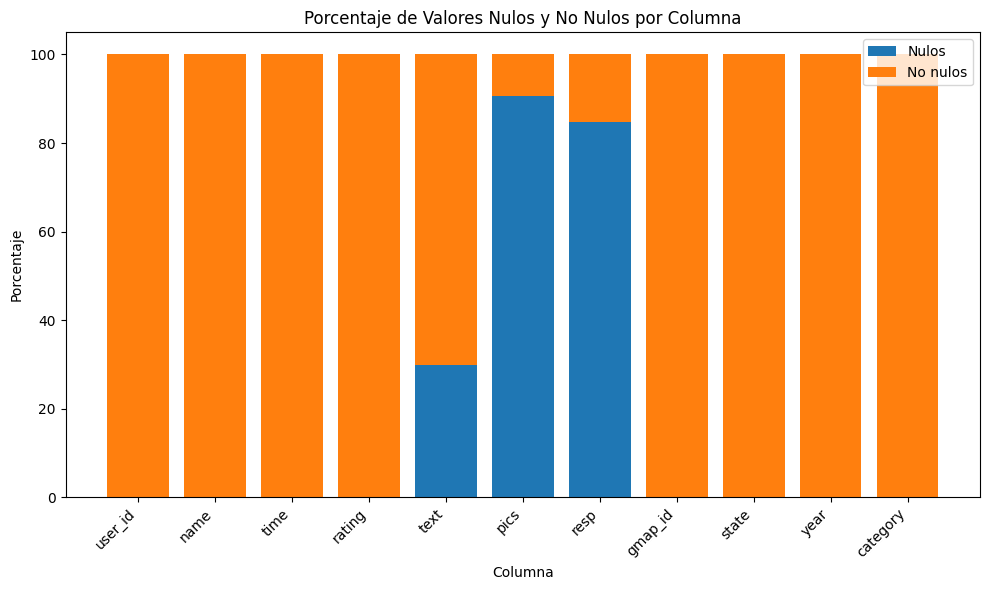

In [23]:
# Calcula el número de valores nulos en cada columna
total_nulos = reviews.isnull().sum()

# Calcula el número total de filas
total_filas = reviews.shape[0]

# Calcula el porcentaje de valores nulos en cada columna
porcentaje_nulos = (total_nulos / total_filas) * 100

# Calcula el porcentaje de valores no nulos en cada columna
porcentaje_no_nulos = 100 - porcentaje_nulos

# Crea un nuevo DataFrame con los resultados
df_nulos_new_jersey = pd.DataFrame({
    'Columna': reviews.columns,
    'Porcentaje nulos': porcentaje_nulos,
    'Porcentaje NO nulos': porcentaje_no_nulos
})

# Configura el tamaño de la figura
plt.figure(figsize=(10, 6))

# Crea un gráfico de barras para los porcentajes de nulos y no nulos
plt.bar(df_nulos_new_jersey['Columna'], df_nulos_new_jersey['Porcentaje nulos'], label='Nulos')
plt.bar(df_nulos_new_jersey['Columna'], df_nulos_new_jersey['Porcentaje NO nulos'], bottom=df_nulos_new_jersey['Porcentaje nulos'], label='No nulos')

# Agregar etiquetas y título
plt.xlabel('Columna')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Valores Nulos y No Nulos por Columna')
plt.xticks(rotation=45, ha='right')
plt.legend()

# Muestra el gráfico
plt.tight_layout()
plt.show()

----

- El 81.33% de los valores en el DataFrame `'florida'` son no nulos, lo que indica que la mayoría de las celdas contienen información válida y completa.
- Este análisis de la distribución de valores nulos y no nulos es esencial para entender la integridad y la calidad de los datos, y puede influir en las decisiones futuras relacionadas con la manipulación y el análisis de este conjunto de datos.

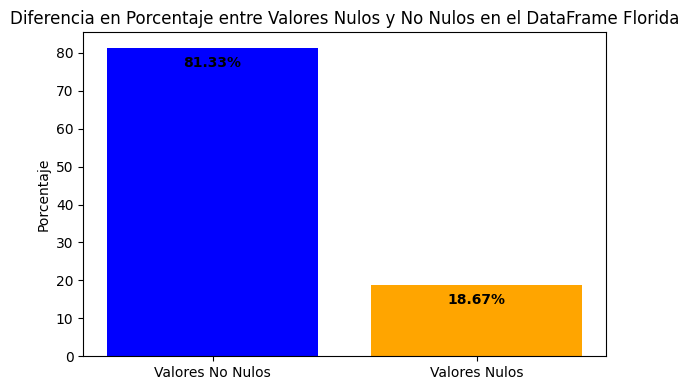

In [24]:
# Calcula el total de valores no nulos y valores nulos en el DataFrame 'florida'
total_valores_no_nulos = reviews.count().sum()
total_valores_nulos = reviews.isnull().sum().sum()

# Calcula el porcentaje de valores no nulos y valores nulos
porcentaje_no_nulos = (total_valores_no_nulos / (total_valores_no_nulos + total_valores_nulos)) * 100
porcentaje_nulos = 100 - porcentaje_no_nulos

# Configura el tamaño de la figura
plt.figure(figsize=(6, 4))

# Crea un gráfico de barras
bars = plt.bar(['Valores No Nulos', 'Valores Nulos'], [porcentaje_no_nulos, porcentaje_nulos], color=['blue', 'orange'])

# Agrega etiquetas y título
plt.ylabel('Porcentaje')
plt.title('Diferencia en Porcentaje entre Valores Nulos y No Nulos en el DataFrame Florida')

# Agrega los porcentajes dentro de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 5, f'{yval:.2f}%', ha='center', color='black', fontweight='bold')

# Muestra el gráfico
plt.tight_layout()
plt.show()


----

Elimina los caracteres especificados de las columnas 'text' y 'resp'

In [25]:
reviews['text'] = reviews['text'].str.replace(')', '').str.replace('(', '').str.replace('&', '').str.replace('.', '')
reviews['resp'] = reviews['resp'].str.replace(')', '').str.replace('(', '').str.replace('&', '').str.replace('.', '')

----

El análisis de las palabras más comunes en los textos de la columna `'text'` del DataFrame `'florida'` revela patrones claros en las reseñas de los locales. La palabra `"great"` lidera con 493,260 ocurrencias, indicando experiencias extremadamente positivas, seguida de `"good"` con 338,383 menciones, denotando evaluaciones favorables. Términos como `"nice"`, `"best"`, `"friendly"` y `"love"` refuerzan una percepción positiva generalizada, mientras que palabras como `"original"`, `"excellent"`, `"amazing"` y `"clean"` resaltan aspectos específicos como autenticidad, calidad y limpieza que los usuarios valoran. Estos resultados enfatizan la tendencia hacia reseñas positivas y una percepción favorable en las experiencias de los usuarios en los locales.

In [26]:
# Lista de palabras a evitar en minúsculas (preposiciones y otras excepciones)
stop_words = ['and', 'the', 'to', 'i', 'a', 'was', 'is', 'for', 'of', 'in', 'my', 'they', 'very', 'it', 'you', 'with','this','have','are','that','on','but','not','place','food','had','service','we','at','me','so','be','always','were','there','get','all','as','staff','will','if','out','go','time','an','just','their','like','your','from','when','by','he','been','no','what','one','here','would','or','our','she','up','people','about','really','do',"it's",'them','has','back','can','only','got','customer','even','never','recommend','more','some','did','work','service','going','because', 'store','other', 'new', 'prices', 'went', "don't", 'her', 'than', 'also', 'after', 'well', 'little','google','his','translated','experience','chicken']

# Crea una función para filtrar palabras vacías y contar ocurrencias en un lote
def count_most_common_words_in_batch(text_batch):
    words = text_batch.split()
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    return Counter(filtered_words)

# Contador de palabras
word_counts = Counter()

# Procesa los textos en partes más pequeñas
batch_size = 10000
num_batches = len(reviews) // batch_size + 1

for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = start_idx + batch_size
    batch_text = ' '.join(reviews['text'].iloc[start_idx:end_idx].dropna())
    batch_word_counts = count_most_common_words_in_batch(batch_text)
    word_counts += batch_word_counts

# Obtiene las palabras más comunes y su conteo
most_common_words = word_counts.most_common(10)  # Cambia 10 por el número deseado

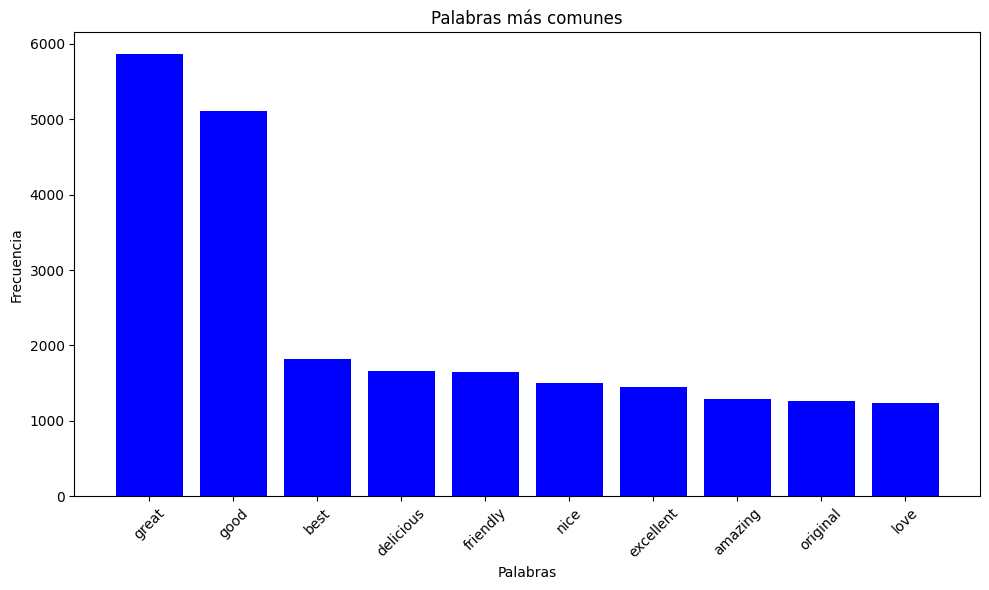

In [27]:
# Extrae las palabras y los conteos para el gráfico
words = [word for word, _ in most_common_words]
counts = [count for _, count in most_common_words]

# Crea el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='blue')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más comunes')
plt.xticks(rotation=45)
plt.tight_layout()

# Muestra el gráfico
plt.show()

In [28]:
# Crea un DataFrame con las palabras más comunes y su conteo
df_most_common_words = pd.DataFrame(most_common_words, columns=['Palabra', 'Cantidad'])

df_most_common_words

,Palabra,Cantidad
0,great,5858
1,good,5108
2,best,1820
3,delicious,1661
4,friendly,1652
5,nice,1506
6,excellent,1454
7,amazing,1291
8,original,1258
9,love,1240


----

La conversión de valores en la columna `'pics'` a 0 o 1 facilita ver cómo las fotos afectan otros aspectos de las reseñas. Ayuda a entender si las fotos influyen en calificaciones, respuestas y participación de usuarios, al simplificar el análisis de su impacto en el conjunto de datos.

In [29]:
# Suponiendo que 'florida' es tu DataFrame
reviews['pics'] = reviews['pics'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else x)

----

Mentenemos solo los registros en el DataFrame `"sitios"` que pertenecen al estado de `"Florida"`.

In [30]:
sitios = sitios[sitios['state'] == 'Florida']

----

## Reviews vs Google Sitios

Comparando la cantidad de registros únicos entre los 2 datasets distintos, vemos que de 2474 restaurants, sólo 751 tienen comentarios.

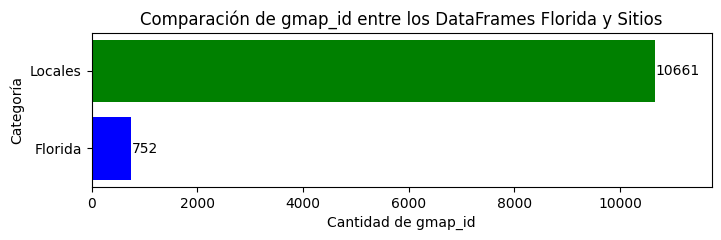

In [31]:
# Datos
reviews_gmap_id_total = len(reviews['gmap_id'].unique())
sitios_gmap_id_total = len(sitios['gmap_id'].unique())

categorias = ['Florida', 'Locales']
cantidades = [reviews_gmap_id_total, sitios_gmap_id_total]

# Crea el gráfico de barras
plt.figure(figsize=(8, 2))
bars = plt.barh(categorias, cantidades, color=['blue','green'])

# Agrega los valores en las barras
for bar in bars:
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, str(int(bar.get_width())), va='center',color='black')

# Ajusta el espacio en blanco antes del marco derecho
plt.xlim(0, max(cantidades) * 1.1)

plt.xlabel('Cantidad de gmap_id')
plt.ylabel('Categoría')
plt.title('Comparación de gmap_id entre los DataFrames Florida y Sitios')

# Muestra el gráfico
plt.show()


----

Este DataFrame tiene 2474 entradas filas y 9 columnas. Cada columna contiene la siguiente información:

1. **name**: Nombre del lugar.
2. **address**: Dirección del lugar.
3. **gmap_id**: Identificador único del lugar en Google Maps.
4. **latitude**: Latitud geográfica del lugar.
5. **longitude**: Longitud geográfica del lugar.
6. **category**: Categoría o tipo del lugar.
7. **avg_rating**: Promedio de calificaciones del lugar.
8. **num_of_reviews**: Número de reseñas u opiniones del lugar.
9. **state**: Estado al que pertenece el lugar.

Este conjunto de datos puede ser utilizado para análisis específicos relacionados con los lugares en el estado de Florida, como identificar las categorías más populares o realizar comparaciones entre lugares en función de las calificaciones y las reseñas recibidas. La información presentada en este DataFrame filtrado puede brindar insights valiosos sobre los lugares en Florida y su desempeño.

In [32]:
sitios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10661 entries, 5 to 156044
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            10661 non-null  object 
 1   address         10661 non-null  object 
 2   gmap_id         10661 non-null  object 
 3   latitude        10661 non-null  float64
 4   longitude       10661 non-null  float64
 5   category        10661 non-null  object 
 6   avg_rating      10661 non-null  float64
 7   num_of_reviews  10661 non-null  int64  
 8   MISC            10661 non-null  object 
 9   state           10661 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 916.2+ KB


----

Comparamos las categorías en Reviews y Sitios

In [33]:
print("Reviews: ", reviews['category'].unique())
print("Sitios: ", sitios['category'].unique())

Reviews:  ['Restaurant']
Sitios:  ['Restaurant' 'Buffet restaurant'
 'Swimming pool supply store, Garden center, Grill store, Hot tub store, Pool cleaning service'
 ...
 'Bar & grill, Convenience store, Lottery retailer, Pizza delivery, Propane supplier, Sandwich shop'
 'Brazilian restaurant, Bistro, Brazilian pastelaria, Diner, Fast food restaurant, Pub, Restaurant'
 'German restaurant, Bar, Restaurant']


----

1. **Distribución de Categorías:**
   - Se observa que la categoría "Restaurant" es la más común en el conjunto de datos, seguida por "Mexican restaurant" y "Pizza restaurant". Esto sugiere una fuerte presencia de lugares de comida en el conjunto de datos.

2. **Variedad de Comida:**
   - La presencia de varias categorías de restaurantes como "Mexican restaurant", "Pizza restaurant", "American restaurant", "Italian restaurant", etc., indica una diversidad en la oferta gastronómica.

3. **Preferencias Culinarias:**
   - La cantidad significativa de "Bar & grill" y "Barbecue restaurant" sugiere una preferencia por opciones de barbacoa y parrilla en la zona.

4. **Rapidez vs. Experiencia Culinaria:**
   - La presencia de "Fast food restaurant" junto con otras categorías de restaurantes podría indicar una combinación de preferencias por opciones rápidas y experiencias gastronómicas más elaboradas.

5. **Cocina Internacional:**
   - La presencia de categorías como "Mexican restaurant", "Italian restaurant" y "Cuban restaurant" señala la disponibilidad de opciones de cocina internacional en la región.

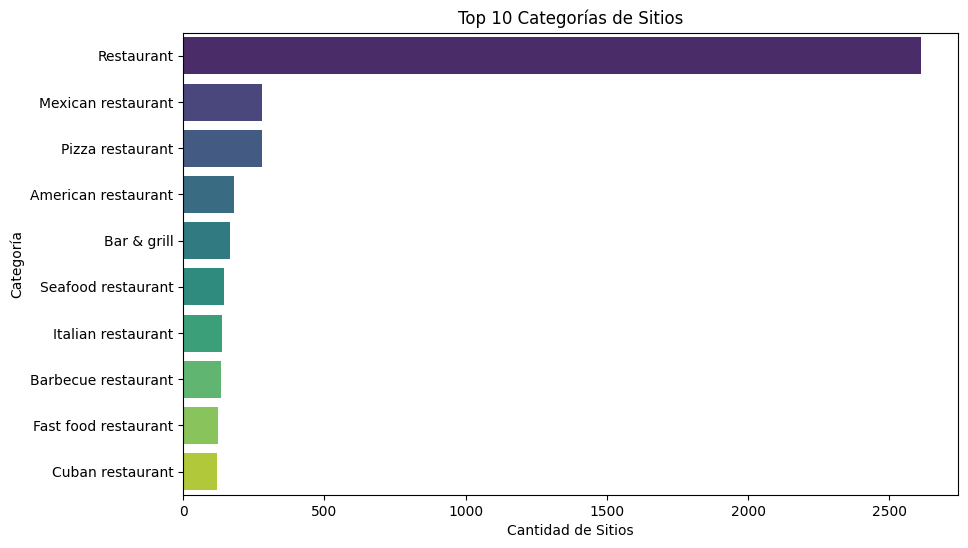

In [34]:
# Obtener las 10 categorías más comunes
top_categories = sitios['category'].value_counts().head(10)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.xlabel('Cantidad de Sitios')
plt.ylabel('Categoría')
plt.title('Top 10 Categorías de Sitios')
plt.show()

In [75]:
# Crear un DataFrame con el top 10 de categorías y su promedio de rating
top_categories_data = []
for category in top_categories:
    avg_rating = sitios[sitios['category'] == category]['avg_rating'].mean()
    top_categories_data.append({'Categoría': category, 'Promedio de Rating': avg_rating})

top_categories_df = pd.DataFrame(top_categories_data)

# Imprimir el DataFrame con las 10 categorías y el promedio de rating
top_categories_df

,Categoría,Promedio de Rating
0,Restaurant,4.294372
1,Mexican restaurant,4.337276
2,Pizza restaurant,4.211111
3,American restaurant,4.259444
4,Bar & grill,4.183832
5,Seafood restaurant,4.262500
6,Italian restaurant,4.313768
7,Barbecue restaurant,4.350746
8,Fast food restaurant,4.240984
9,Cuban restaurant,4.343333


----

Este código realiza las siguientes operaciones:

1. Realiza una fusión (join) entre los DataFrames 'reviews' y 'sitios' utilizando la columna en común 'gmap_id'. Los resultados se almacenan en el DataFrame 'google', y se añaden sufijos '_reviews' y '_sitios' para distinguir las columnas con nombres duplicados.
2. Cambia el nombre de la columna 'name_reviews' a 'user_name'.
3. Elimina la columna 'state_reviews'.
4. Elimina la columna 'category_reviews'.
5. Cambia el nombre de la columna 'name_sitios' a 'site_name'.
6. Calcula la cantidad de comas en cada valor de la columna 'address' y crea una nueva columna 'comma_count' con estos valores.
7. Define una función llamada 'extract_city' que utiliza la información de 'comma_count' y 'address' para extraer el nombre de la ciudad.
8. Aplica la función 'extract_city' para crear una nueva columna 'city' en el DataFrame 'google'.
9. Elimina la columna 'comma_count'.
10. Cambia el nombre de la columna 'category_sitios' a 'category'.
11. Cambia el nombre de la columna 'state_sitios' a 'state'.

En resumen, este código une DataFrames, ajusta nombres de columnas, realiza cálculos basados en los datos de las columnas 'address' y 'comma_count', y finalmente, cambia los nombres de algunas columnas.

In [55]:
# Une los DataFrames por la columna en común "name"
google = pd.merge(reviews, sitios, on='gmap_id', suffixes=('_reviews', '_sitios'))

# Renombra la columna 'name_reviews' como 'user_name'
google.rename(columns={'name_reviews': 'user_name'}, inplace=True)

# Renombra la columna 'category_sitios' como 'category'
google.rename(columns={'category_sitios': 'category'}, inplace=True)

# Elimina la columna 'state_reviews'
google.drop(columns=['state_reviews'], inplace=True)

# Renombra la columna 'name_sitios' como 'site_name'
google.rename(columns={'name_sitios': 'site_name'}, inplace=True)

# Cuenta la cantidad de comas en cada valor de la columna 'address' y agregarlo como una nueva columna 'comma_count'
google['comma_count'] = google['address'].apply(lambda x: x.count(','))

def extract_city(row):
    comma_count = row['comma_count']
    address_parts = row['address'].split(',')

    if len(address_parts) >= comma_count + 1:
        if address_parts[-1].strip() == 'United States':
            comma_count -= 1
        
        return address_parts[comma_count - 1].strip() if comma_count > 0 else None
    else:
        return None

# Aplica la función para crear la columna 'city'
google['city'] = google.apply(extract_city, axis=1)

# Elimina la columna 'comma_count'
google.drop(columns=['comma_count'], inplace=True)

# Elimina la columna 'category_reviews'
google.drop(columns=['category_reviews'], inplace=True)

# Cambia el nombre de la columna 'state_sitios' a 'state'
google.rename(columns={'state_sitios': 'state'}, inplace=True)

In [56]:
google.head()

,user_id,user_name,time,rating,text,pics,resp,gmap_id,year,site_name,address,latitude,longitude,category,avg_rating,num_of_reviews,MISC,state,city
0,115555317336182880909,Hand Pipkin,2021-03-05 08:12:30.931,5,I tried this place before with a friend and I ...,None,None,0x88d9ba5d65937567:0xbc27649cf513cc89,2021,Bachata Rosa,"Bachata Rosa, 887w W 29th St, Hialeah, FL 33012",25.848173,-80.299773,Restaurant,3.6,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,Hialeah
1,116868398574195893423,RBL MIA,2019-04-11 21:09:02.530,5,"Great food, good vibe Friendly staff",None,None,0x88d9ba5d65937567:0xbc27649cf513cc89,2019,Bachata Rosa,"Bachata Rosa, 887w W 29th St, Hialeah, FL 33012",25.848173,-80.299773,Restaurant,3.6,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,Hialeah
2,108980207532919653709,Andres Cabrera,2020-08-24 02:17:49.143,1,Translated by Google I do not recommend it\n\n...,None,None,0x88d9ba5d65937567:0xbc27649cf513cc89,2020,Bachata Rosa,"Bachata Rosa, 887w W 29th St, Hialeah, FL 33012",25.848173,-80.299773,Restaurant,3.6,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,Hialeah
3,117319787586472008973,"Robert Arango, Jr.",2019-10-02 19:25:15.492,5,None,None,None,0x88d9ba5d65937567:0xbc27649cf513cc89,2019,Bachata Rosa,"Bachata Rosa, 887w W 29th St, Hialeah, FL 33012",25.848173,-80.299773,Restaurant,3.6,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,Hialeah
4,105052097044648552825,Ibrahin Piñero,2021-07-24 22:37:39.059,3,None,None,None,0x88d9ba5d65937567:0xbc27649cf513cc89,2021,Bachata Rosa,"Bachata Rosa, 887w W 29th St, Hialeah, FL 33012",25.848173,-80.299773,Restaurant,3.6,8,{'Accessibility': ['Wheelchair accessible entr...,Florida,Hialeah


----

In [58]:
google['category'].unique()

array(['Restaurant'], dtype=object)

----

1. **Distribución de Calificaciones**: Hay un total de 22,086 calificaciones en el conjunto de datos. Las calificaciones se distribuyen en un rango del 1 al 5.

2. **Calificación Promedio**: La calificación promedio es aproximadamente 4.38. Esto sugiere que, en general, las experiencias evaluadas tienden a ser positivas.

3. **Variabilidad de Calificaciones**: La desviación estándar de aproximadamente 1.12 indica que las calificaciones varían en torno a la calificación promedio. Hay cierta variabilidad en las opiniones de los usuarios.

4. **Calificación Mínima**: La calificación mínima es 1, lo que significa que hay al menos algunas experiencias muy negativas según las evaluaciones.

5. **Calificaciones Altas**: El 50% de las calificaciones están en el rango de 4 a 5. Además, el tercer cuartil (Q3) también es 5, lo que indica que el 75% de las calificaciones son 5. Esto sugiere que una gran parte de las calificaciones son altas, lo que podría indicar experiencias positivas en general.

En resumen, las calificaciones en este conjunto de datos parecen ser mayoritariamente positivas, con un promedio cercano a 4.38 y una variabilidad moderada en las opiniones de los usuarios. La mayoría de las calificaciones son altas (4 o 5), pero también hay algunas calificaciones bajas (1).

In [76]:
google['rating'].describe()

count    24114.000000
mean         4.395953
std          1.100767
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

<Axes: xlabel='rating', ylabel='Count'>

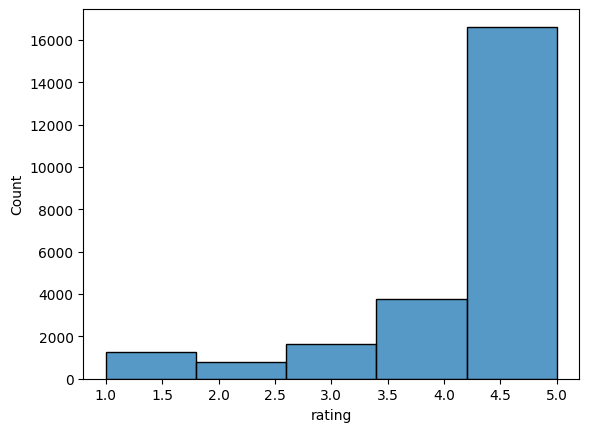

In [77]:
sns.histplot(google['rating'], bins=5)  # kde=True agrega una estimación de la densidad

----

Basado en los promedios de calificaciones por año, podemos llegar a las siguientes conclusiones:

1. **Año 2021**: En 2021, el promedio de calificación es 4.43. Esto sugiere que las experiencias evaluadas durante este año fueron en su mayoría positivas.

2. **Año 2019**: En 2019, el promedio de calificación es 4.37. Parece que las experiencias también fueron evaluadas positivamente durante este año.

3. **Año 2020**: Durante el año 2020, el promedio de calificación es 4.48. Las experiencias parecen haber sido consistentemente buenas, ya que la calificación promedio es alta.

4. **Año 2018**: En 2018, el promedio de calificación es 4.30. Aunque ligeramente menor que otros años, sigue indicando evaluaciones positivas.

5. **Años Anteriores**: En años anteriores como 2015, 2016, 2014, 2017, 2013, y 2011, las calificaciones también son positivas, con promedios que oscilan entre 4.05 y 4.22.

6. **Años Menos Favorables**: Vemos como durante el 2012, el rating de locales tuvo una caida significativa que podría relacionarse con la mejora económica posterior a la crisis de 2008 en Estados Unidos. Con una economía recuperándose, los consumidores tienen más recursos y elevaban sus expectativas. Esto puede llevar a una mayor sensibilidad a la calidad y a menos tolerancia hacia experiencias de menor nivel.

<Axes: xlabel='year', ylabel='rating'>

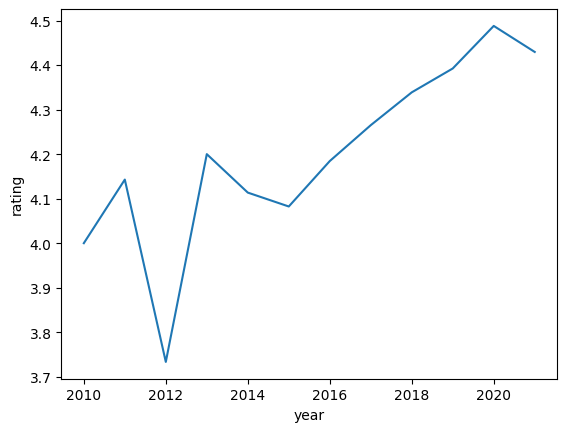

In [78]:
# Filtra las advertencias FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Crea el gráfico sin mostrar el FutureWarning
sns.lineplot(x='year', y='rating', data=google, ci=None)

----

En base a la distribución de años en los datos:

- La mayoría de los registros se concentran en los años más recientes, específicamente en los años 2019, 2020 y 2021.
- Los años anteriores, como 2010-2018, tienen una cantidad significativamente menor de registros en comparación con los años más recientes.
- Los años 2012, 2013 y 2017 también tienen una cantidad moderada de registros.

Estas conclusiones resumen cómo se distribuyen los registros en función de los años y ofrecen una visión general de la frecuencia de las calificaciones a lo largo del tiempo.

<Axes: xlabel='year', ylabel='Count'>

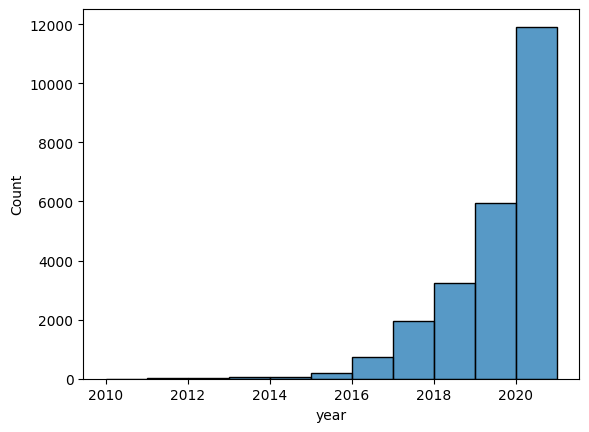

In [79]:
sns.histplot(google['year'], bins=11)  # kde=True agrega una estimación de la densidad